In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import sklearn.ensemble
import sklearn.linear_model
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist


/Users/akaman150/Desktop/nba_predictor_development/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Fetch data and simple preproccessing

In [2]:
# fetch yearly data and remove first 50 games
gbg_22_23 = pd.read_csv('data/gbg_22-23.csv')
gbg_22_23 = gbg_22_23.iloc[:-50]
gbg_21_22 = pd.read_csv('data/gbg_21-22.csv')
gbg_21_22 = gbg_21_22.iloc[:-50]

# combine data and remove unnecessary columns
gbg_data = pd.concat([gbg_21_22, gbg_22_23])
gbg_data = gbg_data.drop('Unnamed: 0', axis=1)
gbg_data.reset_index(drop=True)
gbg_data = gbg_data.drop(['H_TEAM', 'A_TEAM'], axis=1)

# encoding wins as 1/0
gbg_data["H_TEAM_WIN"] = gbg_data["H_TEAM_WIN"].replace({"W": 1, "L": 0})


team_data_majority = gbg_data[gbg_data['H_TEAM_WIN']==1]
team_data_minority = gbg_data[gbg_data['H_TEAM_WIN']==0]

# upscaling minority (adding more home team loss)
# team_data_minority_upsampled = resample(team_data_minority, replace=True, n_samples=team_data_majority.shape[0], random_state=123)
# gbg_data = pd.concat([team_data_majority, team_data_minority_upsampled])

# downscaling majority (removing some home team win)
team_data_majority_downsampled = resample(team_data_majority, replace=False, n_samples=team_data_minority.shape[0], random_state=123)
gbg_data = pd.concat([team_data_majority_downsampled, team_data_minority])

# shuffling combined data
gbg_data = gbg_data.sample(frac=1).reset_index(drop=True)

# normalizing data
game_result = gbg_data["H_TEAM_WIN"]
game_data = gbg_data.drop("H_TEAM_WIN", axis=1)
scaler = skp.StandardScaler()
game_data_scaled = scaler.fit_transform(game_data)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(game_data_scaled, game_result, test_size=0.2, random_state=78)



### Feature selection

In [11]:
# using Recursive Feature Elimination (RFE) to get best features
# Apply RFE

estimator = sklearn.ensemble.RandomForestRegressor()
# estimator = sklearn.linear_model.LinearRegression()
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(game_data, game_result)
rfe_selected_features = game_data.columns[selector.support_]
print(rfe_selected_features)
game_data = game_data[rfe_selected_features]


Index(['H_AVG_PTS', 'H_AVG_FG_PCT', 'H_AVG_DREB', 'A_AVG_PTS', 'A_AVG_FG_PCT',
       'A_AVG_DREB'],
      dtype='object')


### knn example model

In [12]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)


In [15]:
# applying GridsearchCV to the model
param_grid = {
    'n_neighbors': [15, 20, 25, 30, 35, 40, 45, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    }
# grid search
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=20, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=20, wei

accuracy is 0.5617367706919946
mae is 0.43826322930800543
recall is 0.5617367706919946
precision is 0.5616245459258373
r2 is -0.7533143799899835
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       364
           1       0.56      0.58      0.57       373

    accuracy                           0.56       737
   macro avg       0.56      0.56      0.56       737
weighted avg       0.56      0.56      0.56       737



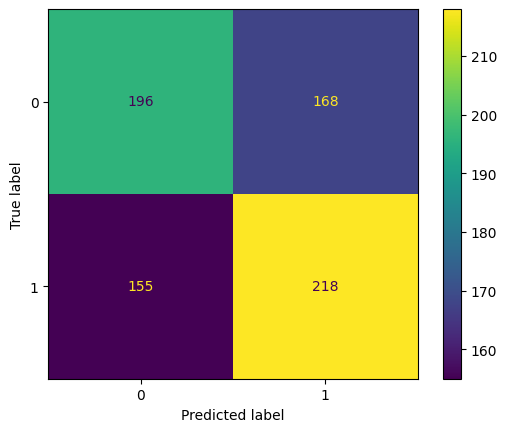

In [16]:
print('accuracy is ' + str(metrics.accuracy_score(y_test, y_pred)))
print('mae is ' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('recall is ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('precision is ' + str(metrics.precision_score(y_test, y_pred, average='weighted')))
print('r2 is ' + str(metrics.r2_score(y_test, y_pred)))


report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

### Neural Network model

In [139]:
# defining the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),  # Input layer with 12 features
    Dense(32, activation='relu'),   # Hidden layer
    Dense(12, activation='relu'),   # Hidden layer
    Dense(1, activation='softmax') # Output layer for binary classification
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, # optimizer for gradient descent
              loss='binary_crossentropy', # loss function for binary classification
              metrics=['binary_accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=13, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {}'.format(test_accuracy))

Epoch 1/10
117/117 [==============================] - 0s 1ms/step - loss: 0.6930 - binary_accuracy: 0.5116 - val_loss: 0.6931 - val_binary_accuracy: 0.4828
Epoch 2/10
117/117 [==============================] - 0s 851us/step - loss: 0.6825 - binary_accuracy: 0.5116 - val_loss: 0.6877 - val_binary_accuracy: 0.4828
Epoch 3/10
117/117 [==============================] - 0s 857us/step - loss: 0.6720 - binary_accuracy: 0.5116 - val_loss: 0.6819 - val_binary_accuracy: 0.4828
Epoch 4/10
117/117 [==============================] - 0s 870us/step - loss: 0.6593 - binary_accuracy: 0.5116 - val_loss: 0.6844 - val_binary_accuracy: 0.4828
Epoch 5/10
117/117 [==============================] - 0s 943us/step - loss: 0.6501 - binary_accuracy: 0.5116 - val_loss: 0.6765 - val_binary_accuracy: 0.4828
Epoch 6/10
117/117 [==============================] - 0s 915us/step - loss: 0.6395 - binary_accuracy: 0.5116 - val_loss: 0.6845 - val_binary_accuracy: 0.4828
Epoch 7/10
117/117 [==============================] - 

Epoch 1/20
48/48 [==============================] - 0s 1ms/step - loss: 0.5874 - binary_accuracy: 0.5116 - val_loss: 0.6860 - val_binary_accuracy: 0.4828
Epoch 2/20
48/48 [==============================] - 0s 1ms/step - loss: 0.5797 - binary_accuracy: 0.5116 - val_loss: 0.6887 - val_binary_accuracy: 0.4828
Epoch 3/20
48/48 [==============================] - 0s 993us/step - loss: 0.5736 - binary_accuracy: 0.5116 - val_loss: 0.6894 - val_binary_accuracy: 0.4828
Epoch 4/20
48/48 [==============================] - 0s 1ms/step - loss: 0.5703 - binary_accuracy: 0.5116 - val_loss: 0.6846 - val_binary_accuracy: 0.4828
Epoch 5/20
48/48 [==============================] - 0s 1ms/step - loss: 0.5645 - binary_accuracy: 0.5116 - val_loss: 0.6926 - val_binary_accuracy: 0.4828
Epoch 6/20
48/48 [==============================] - 0s 1ms/step - loss: 0.5596 - binary_accuracy: 0.5116 - val_loss: 0.6921 - val_binary_accuracy: 0.4828
Epoch 7/20
48/48 [==============================] - 0s 1ms/step - loss: 0.

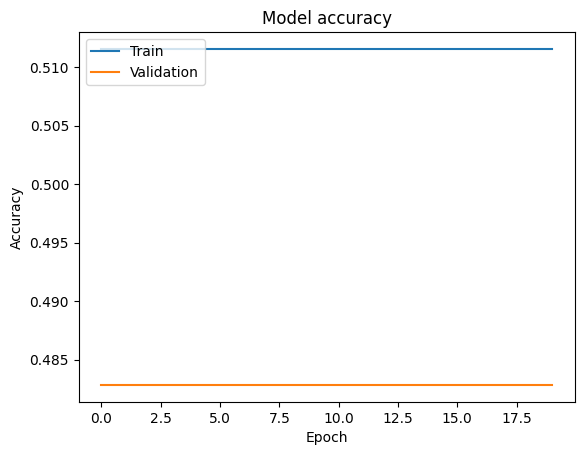

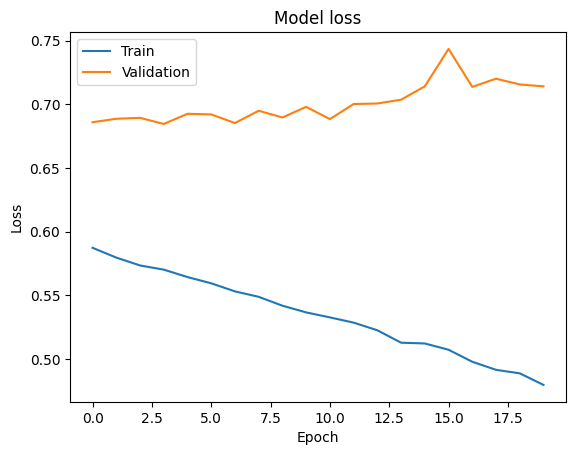

In [140]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 [==============================] - 0s 483us/step
accuracy is 0.4767932489451477
mae is 0.5232067510548524
recall is 0.4767932489451477
precision is 0.22733180223966956
r2 is -1.0973451327433628
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       248
           1       0.48      1.00      0.65       226

    accuracy                           0.48       474
   macro avg       0.74      0.50      0.32       474
weighted avg       0.75      0.48      0.31       474



/Users/akaman150/Desktop/nba_predictor_development/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


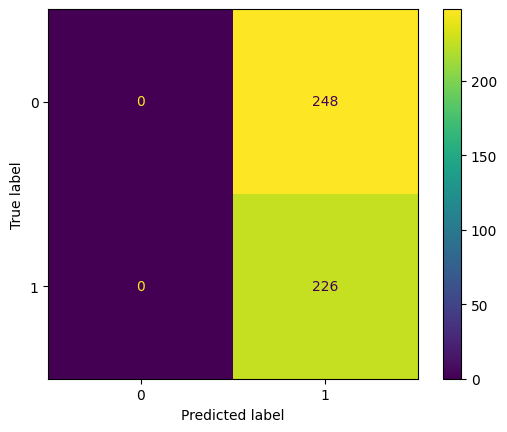

In [141]:
y_pred = model.predict(X_test)
print('accuracy is ' + str(metrics.accuracy_score(y_test, y_pred)))
print('mae is ' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('recall is ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('precision is ' + str(metrics.precision_score(y_test, y_pred, average='weighted')))
print('r2 is ' + str(metrics.r2_score(y_test, y_pred)))


report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()